# Analyzing the Value Premium

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper called "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$
E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML
$$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year long drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts aside the theory and provides a quantitative analysis of the drivers of the value premium and shows that it cannot be concluded that the value premium vanished.

**Data sources:**
* Kenneth French's Academic Portfolios (https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
  * In particular *Fama/French 5 Factors* and *6 Portfolios Formed on Size and Book-to-Market (2 x 3)*
* Robert Shiller's History of Bond Rates (http://www.econ.yale.edu/~shiller/data.htm)

#### Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import jarque_bera, norm, gaussian_kde
from finance_data import FrenchReader, ShillerReader

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
bond_rate = ShillerReader.cape()["10-Year Interest Rate"] / 100
ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100
df = pd.concat([ff3, mom, bond_rate], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "10-Year Interest Rate"]]
portfolio_data = FrenchReader("6_Portfolios_2x3").read()
df

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF,10-Year Interest Rate
1927-01-01,-0.0006,-0.0051,0.0473,NaN,NaN,0.0036,0.0025,0.033400
1927-02-01,0.0418,-0.0025,0.0327,NaN,NaN,-0.0214,0.0026,0.033392
1927-03-01,0.0013,-0.0189,-0.0256,NaN,NaN,0.0361,0.0030,0.033383
1927-04-01,0.0046,0.0049,0.0071,NaN,NaN,0.0430,0.0025,0.033375
1927-05-01,0.0544,0.0146,0.0498,NaN,NaN,0.0300,0.0030,0.033367
...,...,...,...,...,...,...,...,...
2021-08-01,0.0290,-0.0048,-0.0013,-0.0026,-0.0167,0.0252,0.0000,0.012800
2021-09-01,-0.0437,0.0080,0.0509,-0.0194,0.0208,0.0157,0.0000,0.013700
2021-10-01,0.0665,-0.0228,-0.0044,0.0174,-0.0148,0.0321,0.0000,0.015800
2021-11-01,-0.0155,-0.0135,-0.0053,0.0738,0.0160,0.0082,0.0000,0.015600


In [ ]:
univariate_portfolio_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
for dataset in univariate_portfolio_data.keys():
    print(dataset)

In [4]:
univariate_portfolio_data = FrenchReader("6_Portfolios_2x3").read()
for dataset in portfolio_data.keys():
    print(dataset)

Average Value Weighted Returns Monthly
Average Equal Weighted Returns Monthly
Average Value Weighted Returns Annual
Average Equal Weighted Returns Annual
Number of Firms in Portfolios
Average Market Cap
Value Weight Average of BE/ME
Value Weight Average of BE_FYt-1/ME_June
Value Weight Average of OP
Value Weight Average of investment


In [ ]:
portfolio_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
portfolio_data.keys()

## Analysis

Since 2004, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

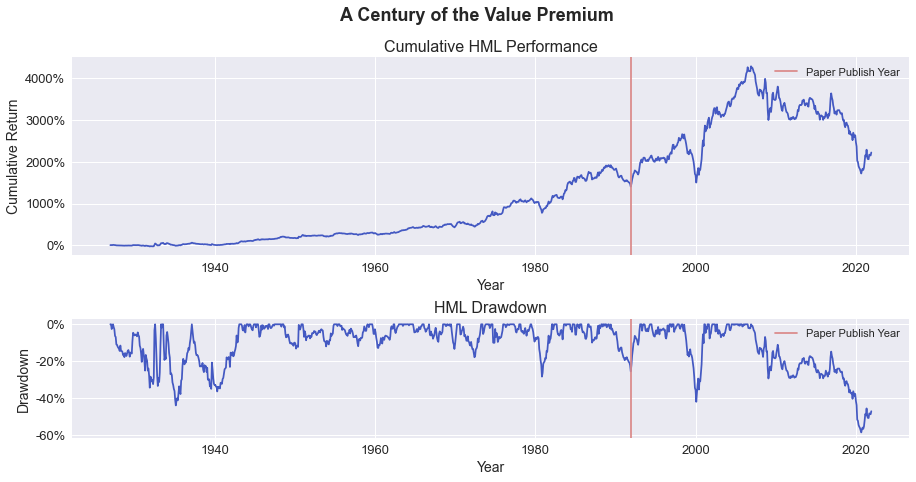

In [5]:
df["HML cumulative"] = (1+df["HML"]).cumprod()
df["HML drawdown"] = df["HML cumulative"] / df["HML cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,7))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(df["HML cumulative"]-1, color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].tick_params(axis="x", labelsize=13)

yticks = np.linspace(0, (df["HML cumulative"]-1).max() // 10 * 10, 5)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[0].legend(fontsize=11, loc="upper right");

axes[1].plot(df["HML drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#db8a8a")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=11, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment

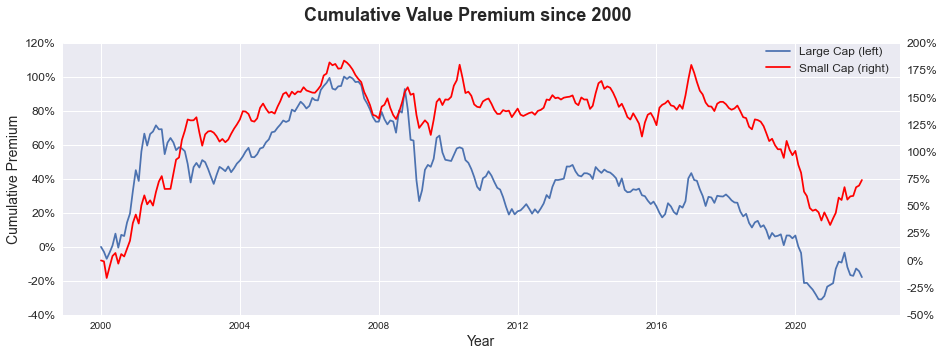

In [6]:
large_premium = (portfolio_data["Average Value Weighted Returns Monthly"]["BIG HiBM"]-portfolio_data["Average Value Weighted Returns Monthly"]["BIG LoBM"]) / 100
small_premium = (portfolio_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"]-portfolio_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"]) / 100

fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax2.grid(False)
fig.suptitle("Cumulative Value Premium since 2000", fontsize=18, fontweight="bold")

ax1.plot((1+large_premium.loc["2000-01-01":].shift(1).fillna(0)).cumprod()-1, label="Large Cap (left)")
ax2.plot((1+small_premium.loc["2000-01-01":].shift(1).fillna(0)).cumprod()-1, label="Small Cap (right)", color="red")

ax1.set_xlabel("Year", fontsize=14)
ax1.set_ylabel("Cumulative Premium", fontsize=14)

yticks1 = ax1.get_yticks().tolist()
ax1.set_yticks(yticks1)
ax1.set_yticklabels([f"{ret:.0%}" for ret in yticks1], fontsize=12)
yticks2 = ax2.get_yticks().tolist()
ax2.set_yticks(yticks2)
ax2.set_yticklabels([f"{ret:.0%}" for ret in yticks2], fontsize=12)

fig.legend(fontsize=12, bbox_to_anchor=(0,0,0.9,0.9));

In [7]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.76% per month with a t-statistic of 3.35.
...the SMB factor returned an average of 0.14% per month with a t-statistic of 0.80.
...the HML factor returned an average of 0.17% per month with a t-statistic of 1.02.

Since 2015,...
...the RMW factor returned an average of 0.36% per month with a t-statistic of 1.66.
...the CMA factor returned an average of -0.15% per month with a t-statistic of -0.75.


With all four factors failing out-of-sample, the question arises whether the factors can deliver any premium going forward.
Aside from the nature of the model itself, there are 3 arguments that, considered individually or together, can invalidate the claim that the recent data points to an arbitraged away value premium:
<br>
1. It can simply be the result of chance.
2. The underperformance is explained by changing investors' taste towards growth stocks
3. Macroeconomic shifts affected value and growth stocks differently

**1. The underperformance is the result of chance**
<br>
Given that all factors carry a sizable amount of risk in the form of volatility, it should be of no surprise that a factor with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of >2% that the process realizes a mean return <0 over a period of 20 years. Likewise, the US market portfolio showed multiple periods of 20 year underperformance against bonds.
<br>
So let's analyze the probability that the HML underperformance is due to chance:

In [8]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
prior_std = df.loc[:"1992-01-01", "HML"].std()

Pior to publication in 1992, the Value Premium had delivered an average monthly excess return of

In [9]:
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [10]:
print(f"{prior_std:.2%}.")

3.68%.


Assuming a gaussian distribution and the same mean and volatility pre- and post-publication, we can compute the probability that the value premium returns an average below the realized average post-publication. Given the increasing number of factor ETFs to give retail investors access to alternative factor premia, and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [11]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 360 months.
The sample size spanning from January 1997 to today is 300 months.
The sample size spanning from January 2002 to today is 240 months.
The sample size spanning from January 2007 to today is 180 months.


Turning to the probabilities, we get the following values.

In [12]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.17% per month is 7.24%
For the subsample from January 1997 to today, the probability of an average return less than 0.05% per month is 2.90%
For the subsample from January 2002 to today, the probability of an average return less than -0.07% per month is 0.39%
For the subsample from January 2007 to today, the probability of an average return less than -0.31% per month is 0.08%


So far, one could certainly (and possibly unsurpringly) argue that the value premium has a structural break between pre- and post-publication of the paper.
However, running the same for a hypothesis of mean 0 post-publication gives the following results:

In [13]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.17% per month is 84.55%
For the subsample from January 1997 to today, the probability of an average return less than 0.05% per month is 61.13%
For the subsample from January 2002 to today, the probability of an average return less than -0.07% per month is 35.60%
For the subsample from January 2007 to today, the probability of an average return less than -0.31% per month is 9.14%


Therefore, based on the assumptions and the mere data, it is not possible to argue that the value premium is dead.
<br>
The biggest issue though is that the empirical distribution of the value premium is indeed non-normal, although I assumed normality until now.

In [14]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue

Its skewness is

In [15]:
np.round(prior_skew, 2)

2.73

and its excess kurtosis is

In [16]:
np.round(prior_kurt, 2)

22.91

, both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution with a significance level <1%

In [17]:
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also shows the extreme kurtosis:

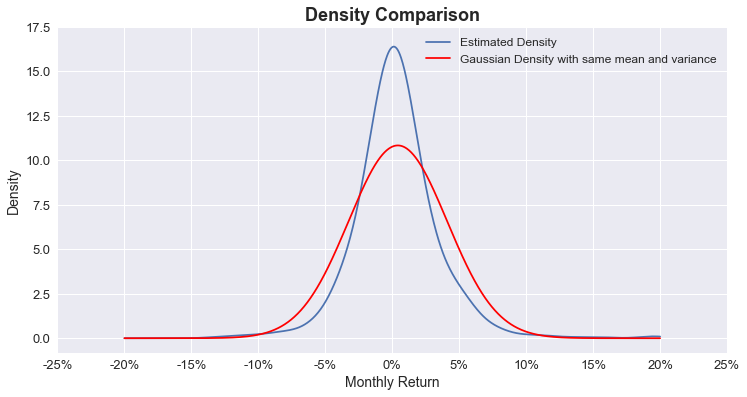

In [33]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])

x = np.linspace(-0.2, 0.2, 1000)
plt.plot(x, estimated_density(x), label="Estimated Density")
plt.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same mean and variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = plt.xticks()[0]
plt.xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = plt.yticks()[0]
plt.yticks(yticks[1:], yticks[1:], fontsize=13)

plt.legend(fontsize=12);

Therefore, it is important to account for the non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times (n=sample size) with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and check the probability of an average return less than the respective realized return.

In [19]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.0284,-0.0015,-0.0134,0.0450,-0.0228,-0.0030,0.0754,0.0068,-0.0074,0.0060,...,-0.0418,0.0559,0.3424,-0.0138,0.0217,0.0021,-0.0062,0.0214,0.0063,0.0552
1,0.0181,0.0073,-0.0152,0.0166,-0.0202,0.1134,0.0453,0.0181,0.0450,-0.0218,...,0.0279,0.0035,0.0145,0.0247,0.0157,-0.0259,-0.0124,-0.0332,0.0166,0.0087
2,-0.0156,-0.0006,0.0393,-0.0096,0.0169,-0.0265,0.0576,-0.0158,0.0054,-0.0161,...,-0.0061,0.0041,0.0161,0.0068,0.0432,0.0197,0.0008,-0.0332,-0.0248,0.0019
3,0.0321,0.0470,0.0082,-0.0367,-0.0249,0.0130,-0.0027,-0.0161,-0.0011,0.0286,...,0.0100,-0.0006,-0.0352,0.0061,-0.0058,0.0160,0.0018,-0.0162,-0.0039,0.0268
4,0.0008,-0.0081,0.1356,0.0176,0.0551,-0.0328,-0.0589,0.0147,0.0047,-0.0155,...,-0.0095,-0.0027,-0.0248,-0.0080,0.0054,-0.0328,0.0085,0.0139,-0.0395,0.0264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-0.0215,0.0322,0.0016,-0.0064,-0.0010,-0.0837,-0.0833,0.0293,0.0047,0.0011,...,0.0247,-0.0076,0.0327,-0.0123,0.0464,0.0214,0.0217,0.0009,0.0453,0.0023
356,0.0214,-0.0410,0.0916,0.0016,-0.0015,0.0104,0.0266,-0.0526,0.0190,0.0220,...,0.0083,0.0407,0.0143,-0.0134,0.0176,0.0023,-0.0142,0.0077,0.0106,-0.0074
357,0.0261,-0.0130,0.0206,-0.0052,-0.0006,-0.0185,-0.0107,-0.0357,0.0055,-0.0405,...,0.0092,-0.0057,-0.0094,0.0023,0.0343,-0.0021,0.0371,0.0168,0.0650,0.0279
358,0.0160,-0.0169,-0.0050,-0.0507,0.0736,0.0019,0.1010,-0.0311,-0.0233,-0.0161,...,0.0228,-0.0085,-0.0017,0.0031,-0.0059,0.0857,0.0200,-0.0273,-0.0135,-0.0857


Let's compute the probability of getting a mean return of less than the realized mean return for each subsample by counting the ocurrences and diving it by the total number of bootstrap samples.

In [20]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.17% per month is 10.03%
For the subsample from January 1997 to today, the probability of an average return less than 0.05% per month is 3.91%
For the subsample from January 2002 to today, the probability of an average return less than -0.07% per month is 1.65%
For the subsample from January 2007 to today, the probability of an average return less than -0.31% per month is 0.26%


And the same results in graphical representation look as follows:

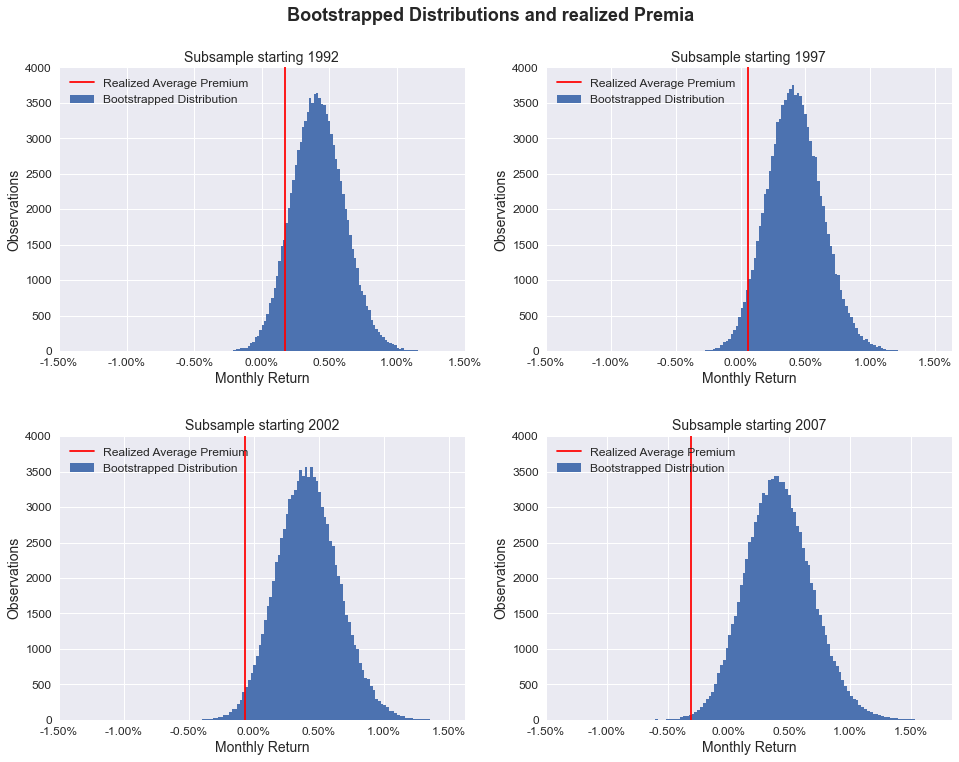

In [21]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=100, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=12)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=12)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than when I assumed normality, the main message remains and the post-publication value premium is either an outlier or the process exhibited a structural break. However, as I have shown, the hypothesis that the mean post-publication is zero cannot be rejected. Therefore, looking at the mere data, there is no indication of a dead value premium.

**2. The underperformance is explained by changing investors' taste**
<br>

**3. Macroeconomic shifts affected value and growth stocks differently**
<br>